# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import DDPGAgent

import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Train an agent

In [8]:
agent = DDPGAgent(state_size, action_size, num_agents)

In [9]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):           # number of episodes, timesteps per, & score window
    task = 0.5                                                    # threshold of score to surpass
    finished = False                                              # checks if agent has finished given task
    scores_total = []                                             # time series of the average score per episode
    averages = []                                                 # smoothing of the scores_total
    scores_deque = deque(maxlen=print_every)                      # limited moving window of ongoing scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset environment, toggle training, get brain
        states = env_info.vector_observations                  # current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize 0 scores (for each agent)
        agent.reset()                                          # initialize a random process N for action exploration
        
        for t in range(max_t):
            actions = agent.act(states)                    # retrieve action for the given state (for each agent)
            env_info = env.step(actions)[brain_name]       # send all actions to the environment
            next_states = env_info.vector_observations     # get next state (for each agent)
            rewards = env_info.rewards                     # get reward (for each agent)
            dones = env_info.local_done                    # see if episode finished
            agent.step(states, actions, rewards, next_states, dones) # save agent's memory of environment     
            scores += rewards                                        # update the score (for each agent)
            states = next_states                                     # roll over states to next time step
            if np.any(dones):                                        # if the agent has finished, stop the loop
                break
        
        average_episode_score = np.mean(scores)         # average score of an episode
        scores_deque.append(average_episode_score)      # time series of average episode score within a window
        scores_total.append(average_episode_score)      # time series of average episode score
        averages.append(np.mean(scores_deque))          # smoothing of the episode averages
        average_score = np.mean(scores_deque)           # average score of a limited window of the scores

        if average_score >= max(averages):                  # save model with highest 'print_every' window score
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
#       if average_episode_score >= max(scores_total):      # save model with highest episode score
#           torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#           torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, average_score), end="")
        if i_episode % print_every == 0:
#           torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#           torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, average_score))
                
        if average_score >= task and finished==False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, average_score))
            finished = True  
#   torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#   torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
    return scores_total, averages

In [10]:
scores, averages = ddpg(n_episodes=4000)

Episode 100	Average Score: -0.004
Episode 200	Average Score: -0.005
Episode 300	Average Score: -0.005
Episode 400	Average Score: -0.005
Episode 500	Average Score: -0.005
Episode 600	Average Score: -0.005
Episode 700	Average Score: -0.005
Episode 800	Average Score: -0.001
Episode 900	Average Score: 0.0060
Episode 1000	Average Score: 0.002
Episode 1100	Average Score: 0.0040
Episode 1200	Average Score: 0.009
Episode 1300	Average Score: 0.027
Episode 1400	Average Score: 0.011
Episode 1500	Average Score: 0.021
Episode 1600	Average Score: 0.067
Episode 1700	Average Score: 0.127
Episode 1800	Average Score: 0.297
Episode 1900	Average Score: 0.102
Episode 2000	Average Score: 0.111
Episode 2100	Average Score: 0.113
Episode 2200	Average Score: 0.374
Episode 2217	Average Score: 0.500
Environment solved in 2217 episodes!	Average Score: 0.500
Episode 2300	Average Score: 0.816
Episode 2400	Average Score: 0.804
Episode 2500	Average Score: 0.337
Episode 2600	Average Score: 0.376
Episode 2700	Average Sc

### Plot online training scores

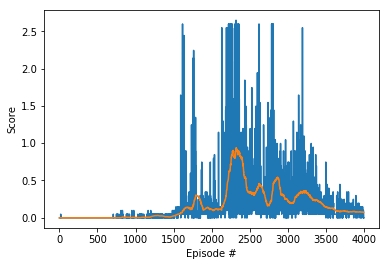

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, averages)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch the trained agent's performance

In [12]:
# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [13]:
for i in range(5):                                         # play game for number of episodes in given range
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, add_noise=False)       # get actions
        env_info = env.step(actions)[brain_name]           # send actions to environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += rewards                                  # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) episode {}: {}'.format(i+1,np.mean(scores)))

Total score (averaged over agents) episode 1: 2.550000037997961
Total score (averaged over agents) episode 2: 0.3950000060722232
Total score (averaged over agents) episode 3: 0.0950000025331974
Total score (averaged over agents) episode 4: 0.09500000160187483
Total score (averaged over agents) episode 5: 2.600000038743019


In [14]:
# If finished, close the environment
env.close()

### Analysis

The agent uses a deep deterministic policy gradient algorithm (DDPG) adjusted to a multi-agent case. In this algorithm, there is an actor and a critic, each with a local approximation and a target approximation. It applies soft-updates, slowly blending the local network weights with the target network weights, and applies noise to its actions to add stochasticity.

The hyperperameters are fairly standard, with a gamma of 0.99 and very small learn rates. I adjusted the noise down a little, but I think this measure will be worth experimenting more with the most because it allows the objective function to be more or less exploratory. The neural networks have two fully connected hidden layers, each with 256 nodes. There's also a line of gradient clipping to stabilize the learning.

I chose to save the weights of the highest average deque of 100 scores, as opposed to simply saving the weights obtained from the highest scoring episode. The reasoning is that the highest scoring epsiode, in this specific, unstable environment, will often be a peak with steep gradients on either of side of it. Parameters saved from this weight could allow the agent to perform very well under certain conditions or by chance, but any action taken by the agent removed from the conditions in which it scored so highly may cause it to fall off the cliff and fail. 

Saving the highest average of a deque also isn't perfect, as the save comes at the rightmost edge of that score window, and can drop off by some amount in the following episode that's outside that scoring window. Yet, it still is more reliable than saving on the highest scoring episode.

Looking at the performance of the trained agent, it did very well in episode 1 and 2, but in episode 2, 3, and 4 it did poorly, falling under the 0.5 score threshold set. It can be seen where the parameter weights were saved by looking at the plot of scores during the agent's online learning. Remember that the scores were saved on the rightmost edge of the deque. Looking at the right periphery of that likely window of 100 scores, we can see a drop-off in performance. There are also probably dips in performance within that window that can't be visualized with that plot.

This same agent, under these same hyperparameters can be trained again, and the results can be wildly different. A lot of it is up to chance, but, with persistence, the learning can be smoothed out to some degree and better can be performance achieved; however, the learning will always have instability with a multi-agent environment in which the agents interact with each other.

We can imagine some variations on the reward structure and the environment as a whole. The current reward structure can be seen as a cooperative one, but if an agent were to receive a bonus reward when the opposing agent fails to return a ball that landed in bounds, then the nature of the learning would change, given that the two agents didn't share neural networks. They would try to exploit patterns in the opposing agent until both neural networks converged and played perfectly, in theory. Or, imagine that each agent has a limited observation range so they can't see the ball unless it is close to them. Small variations in the environment will completely change how the agents interact with each other and how they learn.